<a href="https://colab.research.google.com/github/SvetlanaTsim/recommendation_systems/blob/main/course_project/rec_sys_course_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Финальный проект по курсу "Рекомендательные системы"

Метрики precision@5, money precision@5

Создадим вспомогательные файлы и установим нужные библиотеки

In [3]:
!pip install implicit==0.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.6/18.6 MB 22.0 MB/s eta 0:00:00


In [4]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.4 MB/s eta 0:00:00


In [2]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

In [4]:
# Ignore some warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
#metrics

"""
Metrics for RecSys
"""
import numpy as np


def hit_rate(recommended_list, bought_list):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    flags = np.isin(bought_list, recommended_list)
    return (flags.sum() > 0) * 1


def hit_rate_at_k(recommended_list, bought_list, k=5):
    return hit_rate(recommended_list[:k], bought_list)


def precision(recommended_list, bought_list):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    flags = np.isin(bought_list, recommended_list)
    return flags.sum() / len(recommended_list)


def precision_at_k(recommended_list, bought_list, k=5):
    return precision(recommended_list[:k], bought_list)


def money_precision_at_k(recommended_list, bought_list, prices_recommended, k=5):
    recommended_list = np.array(recommended_list)[:k]
    prices_recommended = np.array(prices_recommended)[:k]
    flags = np.isin(recommended_list, bought_list)
    return np.dot(flags, prices_recommended).sum() / prices_recommended.sum()


def recall(recommended_list, bought_list):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    flags = np.isin(bought_list, recommended_list)
    return flags.sum() / len(bought_list)


def recall_at_k(recommended_list, bought_list, k=5):
    return recall(recommended_list[:k], bought_list)


def money_recall_at_k(recommended_list, bought_list, prices_recommended, prices_bought, k=5):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)[:k]
    prices_recommended = np.array(prices_recommended)[:k]
    prices_bought = np.array(prices_bought)
    flags = np.isin(recommended_list, bought_list)
    return np.dot(flags, prices_recommended).sum() / prices_bought.sum()


def ap_k(recommended_list, bought_list, k=5):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    recommended_list = recommended_list[recommended_list <= k]

    relevant_indexes = np.nonzero(np.isin(recommended_list, bought_list))[0]
    if len(relevant_indexes) == 0:
        return 0
    amount_relevant = len(relevant_indexes)


    sum_ = sum(
        [precision_at_k(recommended_list, bought_list, k=index_relevant + 1) for index_relevant in relevant_indexes])
    return sum_ / amount_relevant

In [6]:
# #utils

"""
Filters for RecSys
"""

import pandas as pd
import numpy as np


def prefilter_items(data, take_n_popular=5000, item_features=None):
    """Prefilter items and take top popular"""

    # Delete rare categories (department)
    if item_features is not None:
        department_size = pd.DataFrame(item_features. \
                                       groupby('department')['item_id'].nunique(). \
                                       sort_values(ascending=False)).reset_index()

        department_size.columns = ['department', 'n_items']
        rare_departments = department_size[department_size['n_items'] < 150].department.tolist()
        items_in_rare_departments = item_features[
            item_features['department'].isin(rare_departments)].item_id.unique().tolist()

        data = data[~data['item_id'].isin(items_in_rare_departments)]

    # Delete cheap items (non profit). Price one purchase from mailing is 1 dollar
    data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))
    data = data[data['price'] > 2]

    # Delete expensive items
    #data = data[data['price'] < 50]

    # Get top popular items
    popularity = data.groupby('item_id')['quantity'].sum().reset_index()
    popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)
    top = popularity.sort_values('n_sold', ascending=False).head(take_n_popular).item_id.tolist()

    # Set a fake id for non popular items
    data.loc[~data['item_id'].isin(top), 'item_id'] = 999999

    return data


def postfilter_items(user_id, recommednations):
    """Postfilter items after fit models"""

    # What time to show?
    # How often to show?
    pass

In [7]:
#MainRecommender

"""
Baseline for RecSys
"""
import pandas as pd
import numpy as np


# For sparse matrix
from scipy.sparse import csr_matrix


# Matrix factorization
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender  # for own recommend
from implicit.nearest_neighbours import bm25_weight, tfidf_weight


class MainRecommender:
    """
    Baseline
    Get base recomendations from ALS or k-nearest algorithms
    Input
    -----
    user_item_matrix: pd.DataFrame
        Matrix user-item conversations
    """

    def __init__(self, data: pd.DataFrame, weighting: bool = True):

        # Top popular purchases of each user
        self.top_purchases = data.groupby(['user_id', 'item_id'])['quantity'].count().reset_index()
        self.top_purchases.sort_values('quantity', ascending=False, inplace=True)
        self.top_purchases = self.top_purchases[self.top_purchases['item_id'] != 999999]

        # Top popular purchases of all dataset
        self.overall_top_purchases = data.groupby('item_id')['quantity'].count().reset_index()
        self.overall_top_purchases.sort_values('quantity', ascending=False, inplace=True)
        self.overall_top_purchases = self.overall_top_purchases[self.overall_top_purchases['item_id'] != 999999]
        self.overall_top_purchases = self.overall_top_purchases.item_id.tolist()

        # Get sparse matrix
        self.user_item_matrix = self._prepare_matrix(data)  # pd.DataFrame
        
        # Get user-item ids map dictionary
        self.id_to_itemid, self.id_to_userid, \
        self.itemid_to_id, self.userid_to_id = self._prepare_dicts(self.user_item_matrix)

        # Weighting matrix for better result
        if weighting:
            self.user_item_matrix = bm25_weight(self.user_item_matrix.T).T

        # Learn two type of models
        self.model = self.fit(self.user_item_matrix)
        self.own_recommender = self.fit_own_recommender(self.user_item_matrix)

    @staticmethod
    def _prepare_matrix(data: pd.DataFrame):
        """Prepare sparse user-item matrix"""
        user_item_matrix = pd.pivot_table(data,
                                          index='user_id',
                                          columns='item_id',
                                          values='quantity',  # variable
                                          aggfunc='count',
                                          fill_value=0
                                          )

        user_item_matrix = user_item_matrix.astype(float)  # necessary matrix type for implicit 

        return user_item_matrix

    @staticmethod
    def _prepare_dicts(user_item_matrix):
        """Prepare ids dictionaries"""

        userids = user_item_matrix.index.values
        itemids = user_item_matrix.columns.values

        matrix_userids = np.arange(len(userids))
        matrix_itemids = np.arange(len(itemids))

        id_to_itemid = dict(zip(matrix_itemids, itemids))
        id_to_userid = dict(zip(matrix_userids, userids))

        itemid_to_id = dict(zip(itemids, matrix_itemids))
        userid_to_id = dict(zip(userids, matrix_userids))

        return id_to_itemid, id_to_userid, itemid_to_id, userid_to_id

    @staticmethod
    def fit_own_recommender(user_item_matrix):
        """Learn model that get item recommendations among user's purchases"""

        own_recommender = ItemItemRecommender(K=1, num_threads=4)
        own_recommender.fit(csr_matrix(user_item_matrix).T.tocsr())

        return own_recommender

    @staticmethod
    def fit(user_item_matrix, n_factors=20, regularization=0.001, iterations=15, num_threads=4):
        """Learn ALS"""

        model = AlternatingLeastSquares(factors=n_factors,
                                        regularization=regularization,
                                        iterations=iterations,
                                        num_threads=num_threads)
        model.fit(csr_matrix(user_item_matrix).T.tocsr())

        return model

    def _update_dict(self, user_id):
        """Update dicts if new user/item has added"""

        if user_id not in self.userid_to_id.keys():
            max_id = max(list(self.userid_to_id.values()))
            max_id += 1

            self.userid_to_id.update({user_id: max_id})
            self.id_to_userid.update({max_id: user_id})

    def _get_similar_item(self, item_id):
        """Find new similar item to item_id"""

        # Get two recs and choose only second because first is self item_id
        recs = self.model.similar_items(self.itemid_to_id[item_id], N=2)  
        top_rec = recs[1][0]
        return self.id_to_itemid[top_rec]

    def _extend_with_top_popular(self, recommendations, N=5):
        """Extend recs with top popular if num of items less than N"""

        if len(recommendations) < N:
            recommendations.extend(self.overall_top_purchases[:N])
            recommendations = recommendations[:N]

        return recommendations

    def _get_recommendations(self, user, model, N=5):
        """Get top-N recommendations from standart algorithms of implicit lib"""

        self._update_dict(user_id=user)
        res = [self.id_to_itemid[rec[0]] for rec in model.recommend(userid=self.userid_to_id[user],
                                                                    user_items=csr_matrix(
                                                                        self.user_item_matrix).tocsr(),
                                                                    N=N,
                                                                    filter_already_liked_items=False,
                                                                    filter_items=[self.itemid_to_id[999999]],
                                                                    recalculate_user=True)]

        res = self._extend_with_top_popular(res, N=N)

        assert len(res) == N, 'Number of recommendations != {}'.format(N)
        return res

    def get_als_recommendations(self, user, N=5):       
        """Get top-N ALS recommendations"""

        return self._get_recommendations(user, model=self.model, N=N)

    def get_own_recommendations(self, user, N=5):
        """Get top-N own item recommendations among user's purchases"""

        return self._get_recommendations(user, model=self.own_recommender, N=N)

    def get_similar_items_recommendation(self, user_id, N=5):
        """Get top-N items similar to user's top popular self purchases"""

        top_users_purchases = self.top_purchases[self.top_purchases['user_id'] == user_id].head(N)

        res = top_users_purchases['item_id'].apply(lambda x: self._get_similar_item(x)).tolist()
        res = self._extend_with_top_popular(res, N=N)

        assert len(res) == N, 'Number of recommendations != {}'.format(N)
        return res

    def get_similar_users_recommendation(self, user_id, N=5):
        """Get top-N items among similar users purchases"""

        res = []

        # Find top-N similar users (get it with 10 reserve users)
        similar_users = self.model.similar_users(self.userid_to_id[user_id], N=N + 11)
        similar_users = [self.id_to_userid[rec[0]] for rec in similar_users]
        similar_users = similar_users[1:]  # delete self user's id from query

        # Get one own recommendation for each similar user
        for _user_id in similar_users:
            _rec = self.get_own_recommendations(_user_id, N=1)
            # add only unique item
            if _rec not in res:
                res.extend(_rec)

        # Cut if redundand
        res = res[:N]

        res = self._extend_with_top_popular(res, N=N)

        assert len(res) == N, 'Number of recommendations != {}'.format(N)
        return res
     

Найдем цены всех товаров (так как одна из метрик money precision).

Цена товара - это среднее цен покупок этого товара по всем юзерам.

In [8]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

In [9]:
data.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.3,1631,1,0.0,0.0


In [10]:
data_pr = data.copy()
data_pr['price'] = data_pr['sales_value'] / (np.maximum(data_pr['quantity'], 1))
data_pr.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,price
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0,1.39
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0,0.82


In [11]:
mean_price = data_pr.groupby(['item_id'])['price'].mean()
mean_price

item_id
25671        3.49
26081        0.99
26093        1.59
26190        1.54
26355        0.99
            ...  
17991689     2.49
17991691     2.49
18000012     4.99
18024155     3.99
18024556    10.17
Name: price, Length: 89051, dtype: float64

Создадим словари с ценой

In [12]:
price_dict = mean_price.to_dict()
price_dict[26355]

0.99

###Вариант 1. Одноуровневая рекомеднательная система

In [47]:
# train test split
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [48]:
#только warm start
data_test = data_test[data_test['item_id'].isin(data_train['item_id'].unique())]
data_test.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2277416,338,41260573635,636,840173,1,1.99,369,0.0,112,92,0.0,0.0
2277417,338,41260573635,636,1037348,1,0.89,369,-0.3,112,92,0.0,0.0
2277418,338,41260573635,636,5592737,2,1.58,369,-0.2,112,92,0.0,0.0
2277419,338,41260573635,636,7441679,1,3.69,369,0.0,112,92,0.0,0.0
2277420,338,41260573635,636,7442317,1,2.69,369,0.0,112,92,0.0,0.0


In [49]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [50]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

In [51]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

In [52]:
# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [54]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

###Implicit AlS

In [55]:
user_item_matrix_bm25 = bm25_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [56]:
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

In [57]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item[userid_to_id[user]],   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False,
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=True)[0]]
    return res

In [58]:
model_b = AlternatingLeastSquares(factors=200, 
                                      regularization=0.001,
                                      iterations=30, 
                                      calculate_training_loss=True, 
                                      num_threads=4)

In [59]:
model_b.fit(user_item_matrix_bm25.T.T.tocsr(),  # На вход item-user matrix
          show_progress=True)
result['ALS_bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model_b, N=5))
result.apply(lambda row: precision_at_k(row['ALS_bm25'] , row['actual']), axis=1).mean()

  0%|          | 0/30 [00:00<?, ?it/s]

0.23057324840764332

Посчитаем money precision@5

In [148]:
def price_recs(recs):
  return [price_dict[rec] for rec in recs]

In [60]:
result.head(2)

,user_id,actual,ALS_bm25
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1082185, 995242, 1033142, 965766, 934369]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1133018, 1092026, 1106523, 1022003, 910032]"


In [63]:
result.apply(lambda row: money_precision_at_k(row['ALS_bm25'] , row['actual'], price_recs(row['ALS_bm25'])), axis=1).mean()

0.22846904547531943

In [65]:
result.apply(lambda row: ap_k(row['ALS_bm25'] , row['actual']), axis=1).mean()

0.0

In [66]:
# Зафиксируем метрики
metrics_df = pd.DataFrame(columns=['model', 'precision@5', 'money_precision@5'])
metrics_df

,model,precision@5,money_precision@5


In [67]:
metrics_df = metrics_df.append({
    'model': 'ALS_bm25',
    'precision@5': result.apply(lambda row: precision_at_k(row['ALS_bm25'] , row['actual']), axis=1).mean(),
    'money_precision@5': result.apply(lambda row: money_precision_at_k(row['ALS_bm25'] , row['actual'], price_recs(row['ALS_bm25'])), axis=1).mean(),
  }, ignore_index=True)

In [68]:
metrics_df

,model,precision@5,money_precision@5
0,ALS_bm25,0.230573,0.228469


Попробуем другие настройки

In [81]:
model_с = AlternatingLeastSquares(factors=200, 
                                      regularization=0.05,
                                      iterations=40, 
                                      calculate_training_loss=True, 
                                      num_threads=4)

In [82]:
model_с.fit(user_item_matrix_bm25.T.T.tocsr(),  # На вход item-user matrix
          show_progress=True)
result['ALS_bm25_1'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model_с, N=5))
result.apply(lambda row: precision_at_k(row['ALS_bm25_1'] , row['actual']), axis=1).mean()

  0%|          | 0/40 [00:00<?, ?it/s]

0.23302302792748653

In [83]:
result.apply(lambda row: money_precision_at_k(row['ALS_bm25_1'] , row['actual'], price_recs(row['ALS_bm25_1'])), axis=1).mean()

0.23079860312077802

In [84]:
metrics_df = metrics_df.append({
    'model': 'ALS_bm25_1',
    'precision@5': result.apply(lambda row: precision_at_k(row['ALS_bm25_1'] , row['actual']), axis=1).mean(),
    'money_precision@5': result.apply(lambda row: money_precision_at_k(row['ALS_bm25_1'] , row['actual'], price_recs(row['ALS_bm25_1'])), axis=1).mean(),
  }, ignore_index=True)

metrics_df

,model,precision@5,money_precision@5
0,ALS_bm25,0.230573,0.228469
1,ALS_bm25_1,0.233023,0.230799


In [101]:
model_d = AlternatingLeastSquares(factors=200, 
                                      regularization=0.135,
                                      iterations=50, 
                                      calculate_training_loss=True, 
                                      num_threads=4)

In [102]:
model_d.fit(user_item_matrix_bm25.T.T.tocsr(),  # На вход item-user matrix
          show_progress=True)
result['ALS_bm25_2'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model_d, N=5))
result.apply(lambda row: precision_at_k(row['ALS_bm25_2'] , row['actual']), axis=1).mean()

  0%|          | 0/50 [00:00<?, ?it/s]

0.23067123958843708

###Вариант 2. Двухуровневая рекоменднательная система

In [104]:
!pip uninstall implicit

Found existing installation: implicit 0.6.0
Uninstalling implicit-0.6.0:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/implicit-0.6.0.dist-info/*
    /usr/local/lib/python3.8/dist-packages/implicit/*
Proceed (Y/n)? y
  Successfully uninstalled implicit-0.6.0


In [1]:
!pip install implicit==0.4.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [123]:
metrics_df.to_csv ('metrics.csv', index= False)

In [150]:
metrics = pd.read_csv('metrics.csv')

In [151]:
metrics

,model,precision@5,money_precision@5
0,ALS_bm25,0.230573,0.228469
1,ALS_bm25_1,0.233023,0.230799


In [13]:
#заново считаем данные
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [14]:
# timeline for train:  -- old purchases -- | -- 6 weeks -- 

VAL_MATCHER_WEEKS = 6

In [15]:
# data for train 1-st layer model (matching)     -- old purchases --
data_train_matcher = data_train_lvl_1

# data for validate 1-st layer model (matching)  -- 6 weeks --
data_val_matcher = data_val_lvl_1

# data for train 2-nd layer model (ranking)      -- 6 weeks --
data_train_ranker = data_train_lvl_2

# data for validate 2-nd layer model (ranking)   -- 3 weeks (test data) --
data_val_ranker = data_val_lvl_2

In [16]:
def print_stats_data(df_data, name_df):
    print(f'{name_df}:')
    print(f"Shape: {df_data.shape} Users: {df_data['user_id'].nunique()} Items: {df_data['item_id'].nunique()}\n")

In [17]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher:
Shape: (2108779, 12) Users: 2498 Items: 83685

val_matcher:
Shape: (169711, 12) Users: 2154 Items: 27649

train_ranker:
Shape: (169711, 12) Users: 2154 Items: 27649

val_ranker:
Shape: (118314, 12) Users: 2042 Items: 24329



In [18]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [19]:
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher:
Shape: (861591, 13) Users: 2495 Items: 5001

val_matcher:
Shape: (169615, 12) Users: 2151 Items: 27644

train_ranker:
Shape: (169615, 12) Users: 2151 Items: 27644

val_ranker:
Shape: (118282, 12) Users: 2040 Items: 24325



In [22]:
data_train_matcher.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,price
7,2375,26984851516,1,1085983,1,2.99,364,-0.40,1642,1,0.0,0.0,2.99
11,1364,26984896261,1,999999,1,2.19,31742,0.00,1520,1,0.0,0.0,2.19
12,1364,26984896261,1,999999,1,2.99,31742,-0.40,1520,1,0.0,0.0,2.99
13,1364,26984896261,1,999999,1,3.09,31742,0.00,1520,1,0.0,0.0,3.09
14,1364,26984896261,1,937406,1,2.50,31742,-0.99,1520,1,0.0,0.0,2.50


In [20]:
recommender = MainRecommender(data_train_matcher)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

In [23]:
recommender.get_als_recommendations(2375, N=5)

[1106523, 871756, 899624, 844179, 1044078]

In [24]:
recommender.get_own_recommendations(2375, N=5)
     

[948640, 918046, 847962, 907099, 873980]

In [25]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1044078, 841220, 824758, 7441873]

In [26]:
recommender.get_similar_users_recommendation(2375, N=5)

[918046, 7146026, 958067, 977559, 861494]

Найдем лучшие параметры для метрики recall

In [27]:
result_eval_matcher = data_val_matcher.groupby('user_id')['item_id'].unique().reset_index()
result_eval_matcher.columns=['user_id', 'actual']
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [28]:
N_PREDICT = 50 

In [29]:
%%time

result_eval_matcher['own_rec'] = result_eval_matcher['user_id'].\
                                    apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

result_eval_matcher['sim_item_rec'] = result_eval_matcher['user_id'].\
                                    apply(lambda x: recommender.get_similar_items_recommendation(x, N=N_PREDICT))

result_eval_matcher['als_rec'] = result_eval_matcher['user_id'].\
                                    apply(lambda x: recommender.get_als_recommendations(x, N=N_PREDICT))

result_eval_matcher['top_rec'] = result_eval_matcher['user_id'].\
                                    apply(lambda x: recommender.overall_top_purchases[:N_PREDICT])

CPU times: user 39 s, sys: 26.2 s, total: 1min 5s
Wall time: 41.2 s


In [30]:
result_eval_matcher.head(2)

,user_id,actual,own_rec,sim_item_rec,als_rec,top_rec
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[839818, 1007512, 9297615, 5577022, 9670830, 9...","[962615, 1082212, 883616, 1119942, 856942, 557...","[1029743, 1106523, 5569230, 916122, 844179, 10..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[8090509, 5569845, 1044078, 985999, 880888, 81...","[5569230, 6534480, 1090931, 1056509, 5569845, ...","[1029743, 1106523, 5569230, 916122, 844179, 10..."


In [31]:
def calc_recall(df_data, top_k=50):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row['actual'], k=top_k), axis=1).mean()

In [32]:
def calc_precision(df_data, top_k=5):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.\
                            apply(lambda row: precision_at_k(row[col_name], row['actual'], k=top_k), axis=1).mean()

In [33]:
TOPK_RECALL = 50

In [34]:
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1], reverse=True)

[('own_rec', 0.06521709430326274),
 ('als_rec', 0.05327871857991624),
 ('top_rec', 0.0432368435310526),
 ('sim_item_rec', 0.03845608237545581)]

**Вывод**

Наилучшим оказался ItemItemRecommender на к=50.

Найдём наилучшие K для recall

In [35]:
top_k_recs = [20, 50, 100, 200, 500, 750, 1000, 1500, 2000]

In [36]:
%%time

for k in top_k_recs:
    name_col = 'own_rec_' + str(k)
    result_eval_matcher[name_col] = result_eval_matcher['user_id'].\
                                        apply(lambda x: recommender.get_own_recommendations(x, N = k))

CPU times: user 49.9 s, sys: 75.7 ms, total: 49.9 s
Wall time: 51.7 s


In [37]:
result_eval_matcher.head(2)

,user_id,actual,own_rec,sim_item_rec,als_rec,top_rec,own_rec_20,own_rec_50,own_rec_100,own_rec_200,own_rec_500,own_rec_750,own_rec_1000,own_rec_1500,own_rec_2000
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[839818, 1007512, 9297615, 5577022, 9670830, 9...","[962615, 1082212, 883616, 1119942, 856942, 557...","[1029743, 1106523, 5569230, 916122, 844179, 10...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[8090509, 5569845, 1044078, 985999, 880888, 81...","[5569230, 6534480, 1090931, 1056509, 5569845, ...","[1029743, 1106523, 5569230, 916122, 844179, 10...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[911974, 1076580, 1103898, 5567582, 1056620, 9..."


Посчитаем recall для каждого k

In [38]:
own_recalls = []

for k in top_k_recs:
    name_col = 'own_rec_' + str(k)
    own_recalls.append(*(calc_recall(result_eval_matcher[['user_id', 'actual', name_col]], k)))

own_recalls = sorted(own_recalls, key=lambda x: x[1], reverse=True)
own_recalls

[('own_rec_2000', 0.2539421298002476),
 ('own_rec_1500', 0.23916233022248096),
 ('own_rec_1000', 0.21673020230871204),
 ('own_rec_750', 0.20031607007656826),
 ('own_rec_500', 0.18193985478066355),
 ('own_rec_200', 0.13536208844757874),
 ('own_rec_100', 0.09598095302917946),
 ('own_rec_50', 0.06521709430326274),
 ('own_rec_20', 0.03926778010950497)]

In [39]:
own_recalls_k = []
for rec in own_recalls[::-1]:
    own_recalls_k.append(rec[1])
own_recalls_k

[0.03926778010950497,
 0.06521709430326274,
 0.09598095302917946,
 0.13536208844757874,
 0.18193985478066355,
 0.20031607007656826,
 0.21673020230871204,
 0.23916233022248096,
 0.2539421298002476]

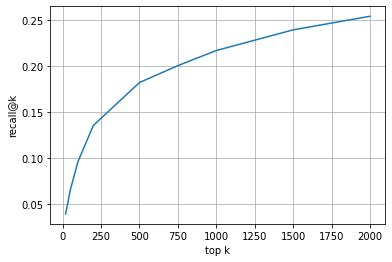

In [40]:
plt.plot(top_k_recs, own_recalls_k)
plt.grid()
plt.xlabel('top k')
plt.ylabel('recall@k')
plt.show()

Наиболее сильно recall увеличивается до k=200. Далее темпы роста снижаются. Поэтому мы примем k=200.

In [78]:
N_PREDICT = 200

In [79]:
# make prefiltered data
data_val_matcher = prefilter_items(data_val_matcher, item_features=item_features, take_n_popular=5000)

In [80]:
# make joined dataset from 1-st layer (matching)  -- old weeks + 6 weeks --
df_join_train_matcher = pd.concat([data_train_matcher, data_val_matcher])

In [82]:
df_join_train_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,price
7,2375,26984851516,1,1085983,1,2.99,364,-0.4,1642,1,0.0,0.0,2.99
11,1364,26984896261,1,999999,1,2.19,31742,0.0,1520,1,0.0,0.0,2.19


In [83]:
# возьмем только уникальных users из train_ranker -- 6 weeks --
df_match_candidates = pd.DataFrame(df_join_train_matcher['user_id'].unique())
df_match_candidates.columns = ['user_id']

In [84]:
df_match_candidates.head()

,user_id
0,2375
1,1364
2,1172
3,1060
4,212


In [85]:
%%time
# get candidates from first stage (matcher)
df_match_candidates['candidates'] = df_match_candidates['user_id'].\
                                        apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

CPU times: user 6.55 s, sys: 5.77 ms, total: 6.56 s
Wall time: 6.61 s


In [86]:
df_match_candidates.head()

,user_id,candidates
0,2375,"[948640, 918046, 847962, 907099, 873980, 88469..."
1,1364,"[1101378, 8090570, 857176, 947013, 1065979, 10..."
2,1172,"[963686, 1057168, 908314, 9859017, 1120261, 10..."
3,1060,"[1021416, 833598, 5566716, 904105, 893729, 988..."
4,212,"[6534078, 8090560, 921277, 8090508, 894360, 10..."


In [87]:
# составим пары user-item
df_items = df_match_candidates.\
                apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

# и присоединим их
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [89]:
df_match_candidates.head(7)

,user_id,item_id
0,2375,948640
0,2375,918046
0,2375,847962
0,2375,907099
0,2375,873980
0,2375,884694
0,2375,10285454


In [90]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates:
Shape: (499000, 2) Users: 2495 Items: 4598



In [91]:
# создаем новый датасет  -- 6 weeks --
df_ranker_train = df_join_train_matcher[['user_id', 'item_id']].copy()
# только покупки
df_ranker_train['target'] = 1
df_ranker_train.head()

,user_id,item_id,target
7,2375,1085983,1
11,1364,999999,1
12,1364,999999,1
13,1364,999999,1
14,1364,937406,1


In [92]:
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=['user_id', 'item_id'], how='left')

# clean dublicates
df_ranker_train = df_ranker_train.drop_duplicates(subset=['user_id', 'item_id'])

df_ranker_train['target'].fillna(0, inplace= True)

In [93]:
df_ranker_train.head()    

,user_id,item_id,target
0,2375,948640,0.0
1,2375,918046,0.0
2,2375,847962,1.0
4,2375,907099,1.0
7,2375,873980,1.0


In [95]:
df_ranker_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 482152 entries, 0 to 753181
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  482152 non-null  int64  
 1   item_id  482152 non-null  int64  
 2   target   482152 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 14.7 MB


In [104]:
df_ranker_train.target.value_counts()

1.0    245884
0.0    236268
Name: target, dtype: int64

In [105]:
df_ranker_train['target'].mean()

0.509971959050258

In [106]:
#X_train, y_train
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2375,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2375,918046,0.0,469,DRUG GM,National,CIGARETTES,CIGARETTES,971838 PK,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [108]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 482152 entries, 0 to 482151
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   user_id               482152 non-null  int64 
 1   item_id               482152 non-null  int64 
 2   manufacturer          482152 non-null  int64 
 3   department            482152 non-null  object
 4   brand                 482152 non-null  object
 5   commodity_desc        482152 non-null  object
 6   sub_commodity_desc    482152 non-null  object
 7   curr_size_of_product  482152 non-null  object
 8   age_desc              155745 non-null  object
 9   marital_status_code   155745 non-null  object
 10  income_desc           155745 non-null  object
 11  homeowner_desc        155745 non-null  object
 12  hh_comp_desc          155745 non-null  object
 13  household_size_desc   155745 non-null  object
 14  kid_category_desc     155745 non-null  object
dtypes: int64(3), obje

###Feature Engeneering

In [109]:
# Get new feature 
def get_feature(group_by, agg_col, agg_func, denominator_flag=False, denominator_num='week_no'):
    # base value of denominator
    denominator = 1
    
    # if flag == true then calculate number of unique value for denominator
    if denominator_flag:
        denominator = df_join_train_matcher[denominator_num].nunique()
    
    # return new column as Series 
    return X_train.merge(df_join_train_matcher.groupby(by=group_by)[agg_col].agg(agg_func)\
                         .rename('new_feature')/denominator, 
                         how='left', 
                         on=group_by).iloc[:, -1].fillna(0)

###Item features

In [110]:
X_train['total_item_sales_value'] = get_feature('item_id', 'sales_value', 'sum')

X_train['total_quantity_value'] = get_feature('item_id', 'quantity', 'sum')

X_train['item_freq'] = get_feature('item_id', 'user_id', 'count')

X_train['item_quantity_per_week'] = get_feature('item_id', 'quantity', 'sum', True, 'week_no')

X_train['item_quantity_per_basket'] = get_feature('item_id', 'quantity', 'sum', True, 'basket_id')

X_train['item_freq_per_basket'] = get_feature('item_id', 'user_id', 'count', True, 'basket_id')

###User features

In [111]:
X_train['user_freq'] = get_feature('user_id', 'user_id', 'count')

X_train['total_user_sales_value'] = get_feature('user_id', 'sales_value', 'sum')

X_train['user_quantity_per_week'] = get_feature('user_id', 'quantity', 'sum', True, 'week_no')

X_train['user_quantity_per_baskter'] = get_feature('user_id', 'quantity', 'sum', True, 'basket_id')

X_train['user_freq_per_basket'] = get_feature('user_id', 'user_id', 'count', True, 'basket_id')  

###User-Item features

In [112]:
X_train['user_item_total_sales'] = get_feature(['user_id', 'item_id'], 'sales_value', 'sum')

X_train['user_item_total_quantity'] = get_feature(['user_id', 'item_id'], 'quantity', 'sum')

X_train['user_item_freq'] = get_feature(['user_id', 'item_id'], 'user_id', 'count')

X_train['user_item_quantity_per_week'] = get_feature(['user_id', 'item_id'], 'quantity', 'sum', True, 'week_no')

X_train['user_item_quantity_per_baskter'] = get_feature(['user_id', 'item_id'], 'quantity', 'sum', True, 'basket_id')

In [113]:
X_train.iloc[:, 15:].head(2)

,total_item_sales_value,total_quantity_value,item_freq,item_quantity_per_week,item_quantity_per_basket,item_freq_per_basket,user_freq,total_user_sales_value,user_quantity_per_week,user_quantity_per_baskter,user_freq_per_basket,user_item_total_sales,user_item_total_quantity,user_item_freq,user_item_quantity_per_week,user_item_quantity_per_baskter
0,323.21,49.0,44.0,0.538462,0.000271,0.000244,292.0,1702.76,4.230769,0.002132,0.001617,0.0,0.0,0.0,0.0,0.0
1,1002.69,222.0,210.0,2.439560,0.001229,0.001163,292.0,1702.76,4.230769,0.002132,0.001617,0.0,0.0,0.0,0.0,0.0


In [114]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 482152 entries, 0 to 482151
Data columns (total 31 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   user_id                         482152 non-null  int64  
 1   item_id                         482152 non-null  int64  
 2   manufacturer                    482152 non-null  int64  
 3   department                      482152 non-null  object 
 4   brand                           482152 non-null  object 
 5   commodity_desc                  482152 non-null  object 
 6   sub_commodity_desc              482152 non-null  object 
 7   curr_size_of_product            482152 non-null  object 
 8   age_desc                        155745 non-null  object 
 9   marital_status_code             155745 non-null  object 
 10  income_desc                     155745 non-null  object 
 11  homeowner_desc                  155745 non-null  object 
 12  hh_comp_desc    

In [115]:
cat_feats = X_train.columns[2:].tolist()

X_train[cat_feats] = X_train[cat_feats].fillna('Unknown')

X_train[cat_feats] = X_train[cat_feats].astype('category')

###Дальше обучаем LightGBM и проверяем на валидации

In [116]:
%%time
lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats,
                     n_jobs=-1,
#                      verbose=0
                   )

lgb.fit(X_train, y_train['target'])

train_preds = lgb.predict_proba(X_train)

CPU times: user 43 s, sys: 177 ms, total: 43.2 s
Wall time: 25.6 s


In [117]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [124]:
(train_preds[:, 1] > 0.5) * 1

array([0, 0, 1, ..., 0, 0, 0])

In [125]:
#предсказания хорошо получились
print(classification_report(y_train, (train_preds[:, 1] > 0.5) * 1))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    236268
         1.0       1.00      1.00      1.00    245884

    accuracy                           1.00    482152
   macro avg       1.00      1.00      1.00    482152
weighted avg       1.00      1.00      1.00    482152



In [126]:
df_ranker_predict = df_ranker_train.copy()

In [127]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]
df_ranker_predict['proba_item_purchase'][:5]

0    5.626570e-07
1    5.626570e-07
2    9.999992e-01
3    9.999992e-01
4    9.999992e-01
Name: proba_item_purchase, dtype: float64

In [128]:
df_ranker_predict.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,proba_item_purchase
0,2375,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.626570e-07
1,2375,918046,0.0,469,DRUG GM,National,CIGARETTES,CIGARETTES,971838 PK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.626570e-07


In [137]:
#df.sort_values(['store',' sales'],ascending= False ). groupby('store').head()

#df_ranker_predict.groupby('user_id')['proba_item_purchase'].list()
df_ranker_sorted = df_ranker_predict.sort_values(['user_id', 'proba_item_purchase'],ascending= False ).groupby('user_id').head()
df_ranker_sorted.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,proba_item_purchase
279633,2500,13382327,1.0,544,GROCERY,National,BAG SNACKS,TORTILLA/NACHO CHIPS,20 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
279654,2500,13039424,1.0,5143,DRUG GM,National,GREETING CARDS/WRAP/PARTY SPLY,CARDS SEASONAL,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
279532,2500,12808385,1.0,2384,GROCERY,National,BEERS/ALES,BEERALEMALT LIQUORS,6PK/12OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
279576,2500,12757065,1.0,2007,PRODUCE,National,VALUE ADDED FRUIT,APPLES WEDGE/SLICES,14 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
279620,2500,12517450,1.0,3951,SEAFOOD,National,SEAFOOD - FROZEN,SEAFOOD-FRZ-IQF RAW SHRIMP RW,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [140]:
df_ranker_sorted.loc[df_ranker_sorted['user_id'] == 25]

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,proba_item_purchase
34440,25,13008065,1.0,794,GROCERY,National,FRZN BREAKFAST FOODS,WAFFLES/PANCAKES/FRENCH TOAST,14.1 OZ,35-44,U,50-74K,Unknown,Unknown,1,None/Unknown,1.0
34469,25,12949590,1.0,1604,GROCERY,National,BAG SNACKS,POTATO CHIPS,11 OZ,35-44,U,50-74K,Unknown,Unknown,1,None/Unknown,1.0
34470,25,13190524,1.0,1266,GROCERY,National,MOLASSES/SYRUP/PANCAKE MIXS,MOLASSES & SYRUPS,27.6 OZ,35-44,U,50-74K,Unknown,Unknown,1,None/Unknown,1.0
34498,25,13506200,1.0,4411,MEAT,National,BEEF,ANGUS,,35-44,U,50-74K,Unknown,Unknown,1,None/Unknown,1.0
34439,25,9364612,1.0,1790,PASTRY,National,BREAKFAST SWEETS,SW GDS:DONUTS,8.6 OZ,35-44,U,50-74K,Unknown,Unknown,1,None/Unknown,1.0


In [141]:
#теперь надо выбрать топ-5 предсказаний для каждого юзера
result_eval_ranker_user_id = df_ranker_sorted.groupby('user_id')['item_id'].unique().reset_index()
result_eval_ranker_user_id .columns=['user_id', 'LGBM_recs']
result_eval_ranker_user_id.head()

,user_id,LGBM_recs
0,1,"[15926844, 13877012, 9655212, 9527558, 9677939]"
1,2,"[13189726, 12425418, 9707240, 9676721, 9653714]"
2,3,"[12812474, 12524016, 12648296, 9677270, 9526628]"
3,4,"[12385477, 12386122, 12385373, 9677093, 10282046]"
4,5,"[13073175, 9677093, 9677270, 9677949, 6513604]"


In [142]:
#проверяем на завершающей валидации
result_eval_ranker = data_val_ranker.groupby('user_id')['item_id'].unique().reset_index()
result_eval_ranker.columns=['user_id', 'actual']
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [143]:
result_with_LGBM = result_eval_ranker.merge(result_eval_ranker_user_id, on='user_id', how='left')
result_with_LGBM

,user_id,actual,LGBM_recs
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[15926844, 13877012, 9655212, 9527558, 9677939]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[12812474, 12524016, 12648296, 9677270, 9526628]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[13003092, 13002975, 13115971, 13115375, 12757..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[13213082, 13777408, 13040302, 9803591, 9527187]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[13007912, 13213106, 9677670, 9655212, 9704731]"
...,...,...,...
2035,2496,[6534178],"[13910296, 13382073, 12810464, 12810422, 13007..."
2036,2497,"[1016709, 9835695, 1132298, 16809501, 845294, ...","[12812261, 13115894, 13159268, 13072850, 13040..."
2037,2498,"[15716530, 834484, 901776, 914190, 958382, 972...","[13133916, 13910296, 12949855, 13876345, 15778..."
2038,2499,"[867188, 877580, 902396, 914190, 951590, 95813...","[13907062, 13382073, 15778319, 9523059, 9575582]"


In [144]:
TOPK_PRECISION = 5

In [145]:
precision5 = result_with_LGBM.apply(lambda row: precision_at_k(row['LGBM_recs'], row['actual']), axis=1).mean()
precision5 

0.04715686274509804

In [149]:
mp_5 = result_with_LGBM.apply(lambda row: money_precision_at_k(row['LGBM_recs'], row['actual'],  price_recs(row['LGBM_recs'])), axis=1).mean()
mp_5

0.04457100128738522

In [152]:
metrics = metrics.append({
    'model': '2_levels_II_LightGBM',
    'precision@5': precision5 ,
    'money_precision@5': mp_5,
  }, ignore_index=True)

metrics

,model,precision@5,money_precision@5
0,ALS_bm25,0.230573,0.228469
1,ALS_bm25_1,0.233023,0.230799
2,2_levels_II_LightGBM,0.047157,0.044571


In [155]:
metrics.sort_values(by='money_precision@5', ascending=False)

,model,precision@5,money_precision@5
1,ALS_bm25_1,0.233023,0.230799
0,ALS_bm25,0.230573,0.228469
2,2_levels_II_LightGBM,0.047157,0.044571


**Вывод:**
на текущий момент по метрике money_precision@5 наилучший результат **0.230799** дала модель ALS со взвешиванием bm25.